Goal: Explore Data Provided by WDL on Urban Mobility

In [1]:
# import necessary packages
import os
import pandas as pd
import numpy as np
from scipy.special import boxcox1p
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# build data directory
data_dir = '../../data/stage1'
os.listdir(data_dir)

['Churn_OD.txt',
 'Churn_UsersProfile.txt',
 'stage_1_challenge_1_dictionary.xlsx']

### 1: Churn User Profile Data
We will be examining this first

In [3]:
# Load user profiles
user_profiles_df = pd.read_csv(
    os.path.join(data_dir, 'Churn_UsersProfile.txt'), 
    delimiter = "|",
    encoding = "ISO-8859-1"
)

#### 1.1: Inspect Data

In [4]:
# sample some user profiles
user_profiles_df.sample(5)

,Region_of_Origin,District_of_Origin,County_of_Origin,Period,GenderDescription,AgeClassDescription,Average_BusUsers_per_Day
270,R1 - AM Lisboa,Lisboa,Cascais,Sep-20 to Jan-21,Female,45-54,670.410921
505,R2 - AM Porto,Porto,Póvoa de Varzim,Sep-20 to Jan-21,Male,25-34,39.465245
32,R1 - AM Lisboa,Lisboa,Lisboa,Sep-19 to Feb-20,Male,55-64,1714.973185
38,R1 - AM Lisboa,Lisboa,Loures,Sep-19 to Feb-20,Female,55-64,264.211066
356,R1 - AM Lisboa,Setúbal,Alcochete,Sep-20 to Jan-21,Male,35-44,157.793211


In [5]:
# No missing data -> Fantastic
user_profiles_df.isna().sum()

Region_of_Origin            0
District_of_Origin          0
County_of_Origin            0
Period                      0
GenderDescription           0
AgeClassDescription         0
Average_BusUsers_per_Day    0
dtype: int64

In [6]:
user_profiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Region_of_Origin          544 non-null    object 
 1   District_of_Origin        544 non-null    object 
 2   County_of_Origin          544 non-null    object 
 3   Period                    544 non-null    object 
 4   GenderDescription         544 non-null    object 
 5   AgeClassDescription       544 non-null    object 
 6   Average_BusUsers_per_Day  544 non-null    float64
dtypes: float64(1), object(6)
memory usage: 29.9+ KB


In [7]:
# no duplicate rows!
user_profiles_df.duplicated().sum()

0

#### 1.2: Basic Data Wrangling
-  Make a new column for R1/R2 from Region_of_Origin
-  Make a new column for Region of origin anything after `- AM`
-  Convert columns to categorical
-  Separate period to `period_start`, `period_end` and `period_length`

Assumptions:
-  Period start is on the first day of the month and up to the final day in the last month

In [8]:
# make new columns from Region_of_Origin
user_profiles_df['origin_region_number'] = user_profiles_df['Region_of_Origin'].str.split(' ').str[0]
user_profiles_df['origin_region'] = user_profiles_df['Region_of_Origin'].str.split('- AM',1).str[1]
user_profiles_df.drop('Region_of_Origin', axis=1, inplace=True)

In [9]:
# # split period to period_start and period_end (assume from first day of month to last)
# user_profiles_df['period_start'] = user_profiles_df['Period'].str.split('to').str[0]
# user_profiles_df['period_end'] = user_profiles_df['Period'].str.split('to',1).str[-1]
# user_profiles_df.drop('Period', axis=1, inplace=True)

In [10]:
# from datetime import datetime, timedelta

# user_profiles_df['period_start'] = user_profiles_df['period_start'].apply(lambda x: datetime.strptime(x.strip(), '%b-%y'))
# user_profiles_df['period_end'] = user_profiles_df['period_end'].apply(lambda x: datetime.strptime(x.strip(), '%b-%y'))

# def last_day_of_month(date):
#     if date.month == 12:
#         return date.replace(day=31)
#     return date.replace(month=date.month+1, day=1) - timedelta(days=1)

# user_profiles_df['period_end'] = user_profiles_df['period_end'].apply(last_day_of_month)

In [11]:
# There are only two periods that we have; seems like wrangling dates wasn't necessary
user_profiles_df['Period'].value_counts()

Sep-20 to Jan-21    289
Sep-19 to Feb-20    255
Name: Period, dtype: int64

In [12]:
# convert types to categorical
to_cat_cols = ['District_of_Origin','County_of_Origin','Period','GenderDescription','AgeClassDescription','origin_region_number','origin_region']
for col in to_cat_cols:
    user_profiles_df[col] = user_profiles_df[col].astype('category')

#### 1.3: Plots

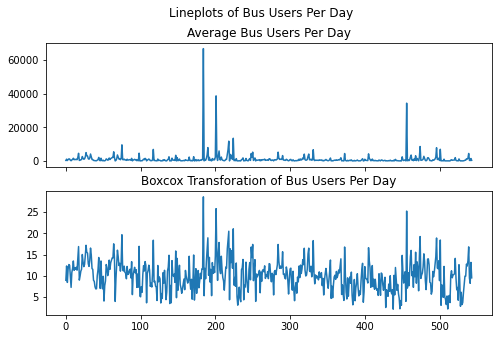

In [13]:
# Lineplots of Average Bus Users Per Day
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8,5))
fig.suptitle('Lineplots of Bus Users Per Day')

ax1.plot(user_profiles_df['Average_BusUsers_per_Day']);
ax1.set(title='Average Bus Users Per Day');

ax2.plot(boxcox1p(user_profiles_df['Average_BusUsers_per_Day'], 0.15));
ax2.set(title='Boxcox Transforation of Bus Users Per Day');
plt.show()

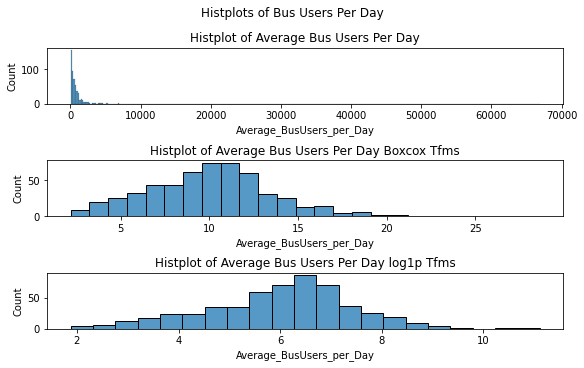

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(8, 5), constrained_layout=True)
fig.suptitle('Histplots of Bus Users Per Day')

sns.histplot(user_profiles_df['Average_BusUsers_per_Day'], ax=axs[0]);
axs[0].set(title='Histplot of Average Bus Users Per Day');

sns.histplot(boxcox1p(user_profiles_df['Average_BusUsers_per_Day'], 0.15), ax=axs[1]);
axs[1].set(title='Histplot of Average Bus Users Per Day Boxcox Tfms');

sns.histplot(np.log1p(user_profiles_df['Average_BusUsers_per_Day']), ax=axs[2]);
axs[2].set(title='Histplot of Average Bus Users Per Day log1p Tfms');
plt.show()

Looks like applying a log1p transformation transforms the distribution to a normal one; we'll do that and plot with it.

In [15]:
user_profiles_df['log1p_avg_daily_bus_users'] = np.log1p(user_profiles_df['Average_BusUsers_per_Day'])

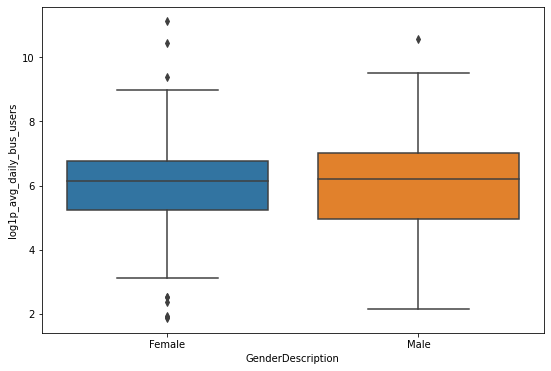

In [16]:
plt.figure(figsize=(9,6))
sns.boxplot(x='GenderDescription', y='log1p_avg_daily_bus_users',data=user_profiles_df);

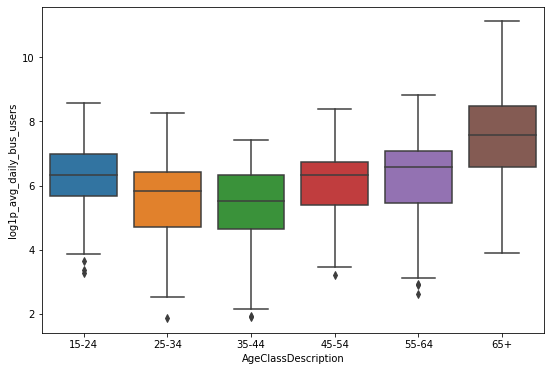

In [17]:
plt.figure(figsize=(9,6))
sns.boxplot(x='AgeClassDescription', y='log1p_avg_daily_bus_users',data=user_profiles_df);

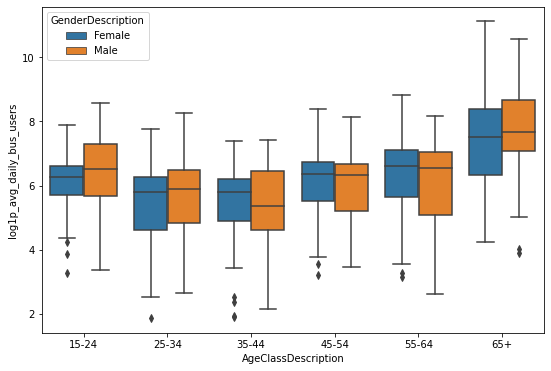

In [18]:
# look at average bus users per day by gender
plt.figure(figsize=(9,6))
sns.boxplot(x='AgeClassDescription', y='log1p_avg_daily_bus_users', hue='GenderDescription',data=user_profiles_df);

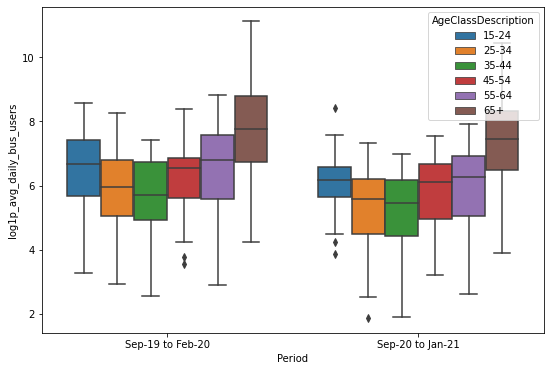

In [19]:
plt.figure(figsize=(9,6))
sns.boxplot(x='Period', y='log1p_avg_daily_bus_users', hue='AgeClassDescription',data=user_profiles_df);

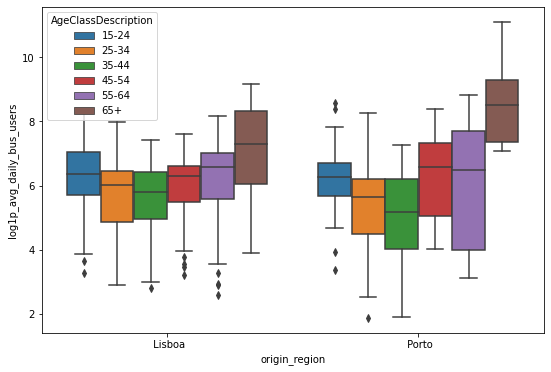

In [20]:
plt.figure(figsize=(9,6))
sns.boxplot(x='origin_region', y='log1p_avg_daily_bus_users', hue='AgeClassDescription',data=user_profiles_df);

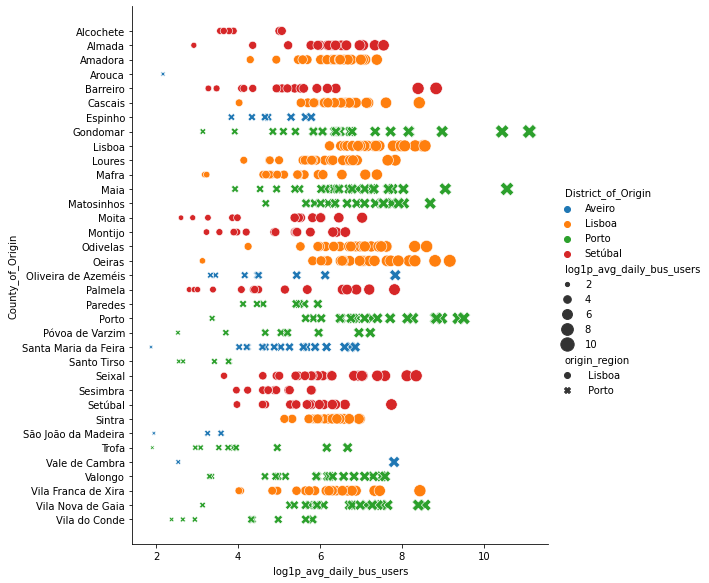

In [21]:
sns.relplot(
    y='County_of_Origin', 
    x='log1p_avg_daily_bus_users', 
    hue='District_of_Origin', 
    size='log1p_avg_daily_bus_users',
    style='origin_region',
    sizes=(15,200),
    data=user_profiles_df,
    height=8
);

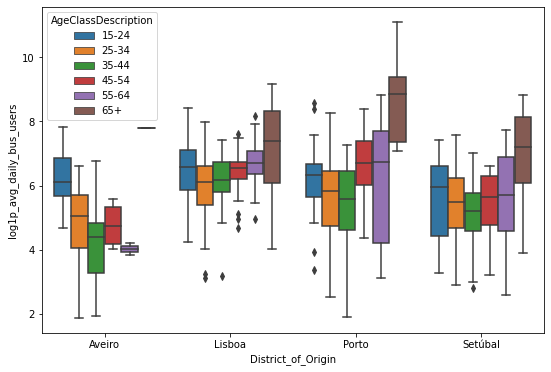

In [22]:
plt.figure(figsize=(9,6))
sns.boxplot(x='District_of_Origin', y='log1p_avg_daily_bus_users', hue='AgeClassDescription',data=user_profiles_df);

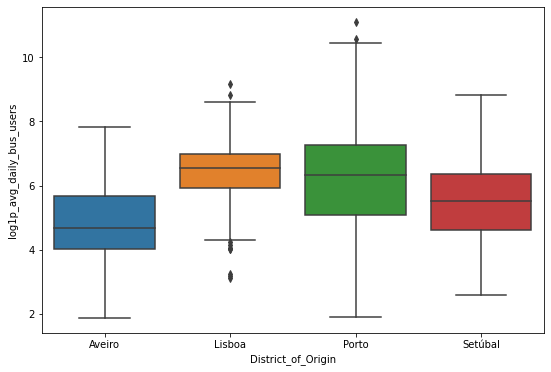

In [23]:
plt.figure(figsize=(9,6))
sns.boxplot(x='District_of_Origin', y='log1p_avg_daily_bus_users',data=user_profiles_df);

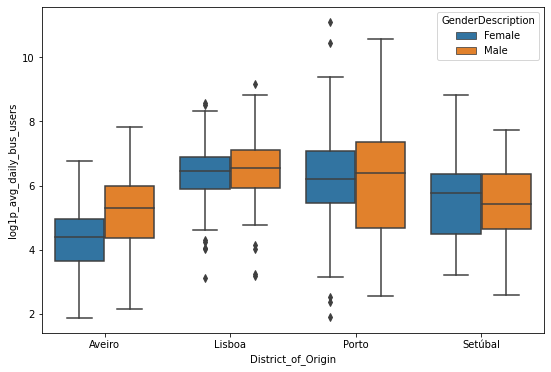

In [24]:
plt.figure(figsize=(9,6))
sns.boxplot(x='District_of_Origin', y='log1p_avg_daily_bus_users', hue='GenderDescription',data=user_profiles_df);

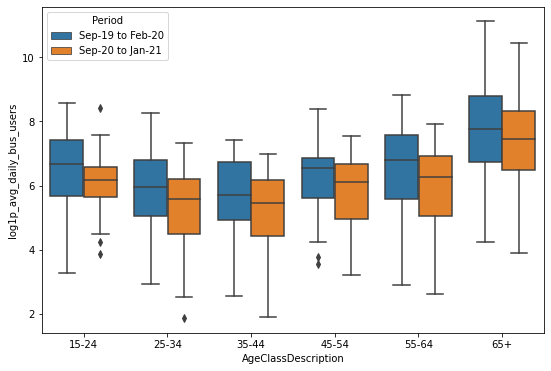

In [25]:
plt.figure(figsize=(9,6))
sns.boxplot(x='AgeClassDescription', y='log1p_avg_daily_bus_users', hue='Period',data=user_profiles_df);

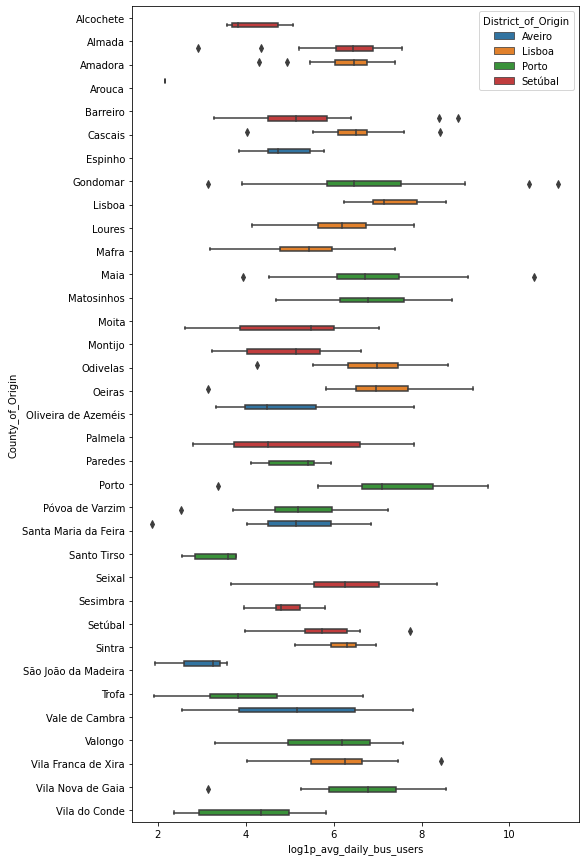

In [26]:
plt.figure(figsize=(8,15))
sns.boxplot(x='log1p_avg_daily_bus_users', y='County_of_Origin', hue='District_of_Origin',data=user_profiles_df, orient='h');

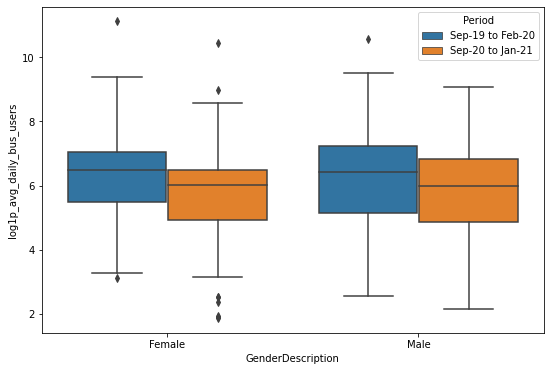

In [27]:
plt.figure(figsize=(9,6))
sns.boxplot(x='GenderDescription', y='log1p_avg_daily_bus_users', hue='Period',data=user_profiles_df);

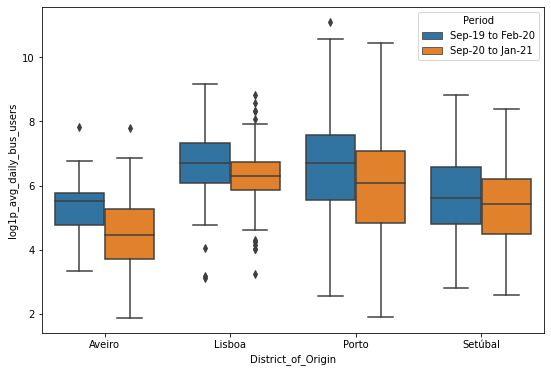

In [28]:
plt.figure(figsize=(9,6))
sns.boxplot(x='District_of_Origin', y='log1p_avg_daily_bus_users', hue='Period',data=user_profiles_df);

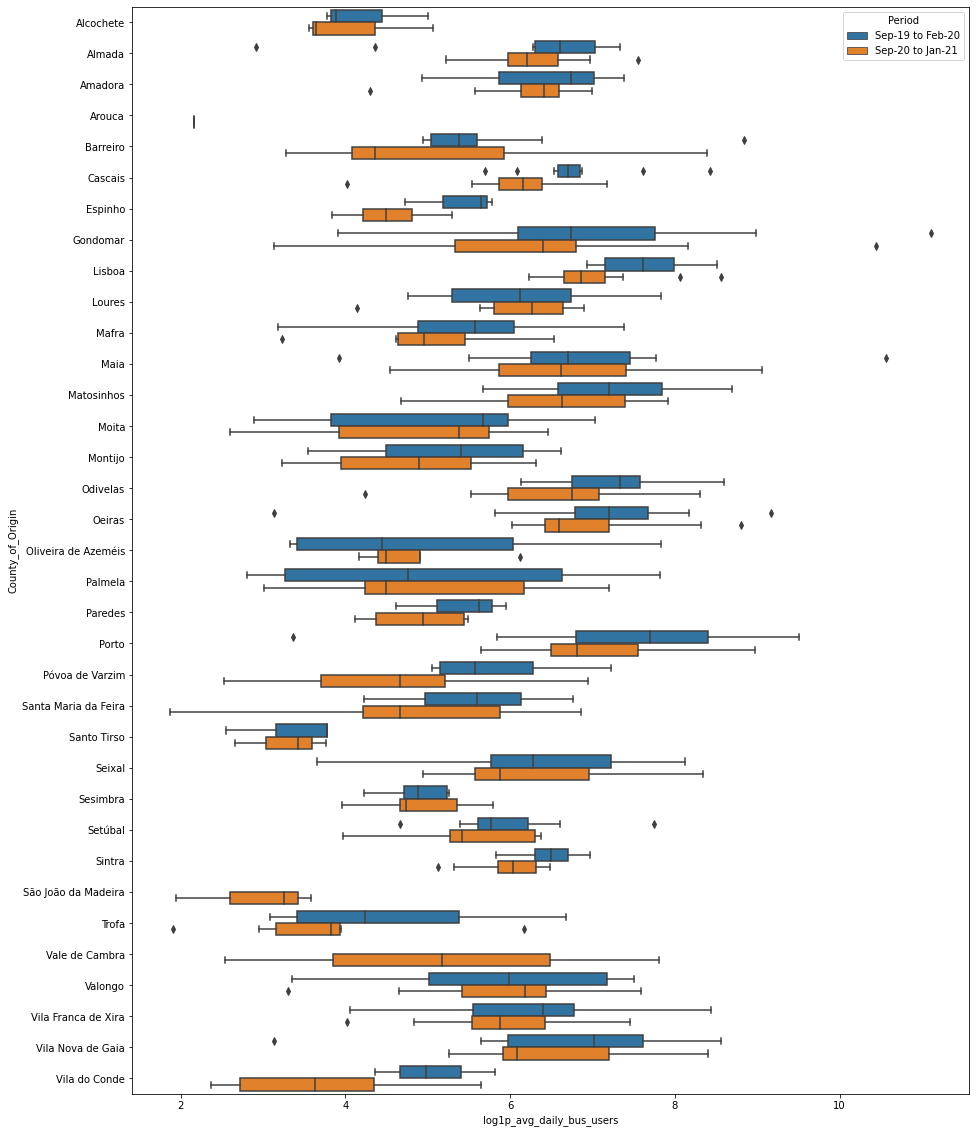

In [29]:
plt.figure(figsize=(15,20))
sns.boxplot(y='County_of_Origin', x='log1p_avg_daily_bus_users', hue='Period',data=user_profiles_df, orient='h');

Findings:
-  Males and females have similar median, upper and lower ranges however there are more extreme cases for female bus users
-  Elderly (65+) have the highest median for usage of busses; middle age (35-44) have the lowest median
-  Female middle age have the lowest bus usage in age range (35-44) and slightly higher than males in age range (15-24)
-  There were slightly more users from Sep-2020 to Jan 2021 than Sep-19 to Feb-20
    -  Slight confusion as Pandemic hit Europe around March 2020? So Sep-20 to Jan-2021 is during the pandemic. Do we discount this information? <br>
    Response: Recover some "normality"; Sep-19 to Feb-20 is pre-pandemic and after is post pandemic however no longer under national lockdown so there is still some transportation
    -  Age demographics remain consistent for both of the time periods; elderly rely heavily on public transport
-  Gondomar and Maia have the highest avg_daily_bus_users
-  District of Origin makes a big difference; ages within that vary widely too; Aveiro have the lowest number of daily bus users and Famels from Aveiro even lower
-  Average daily bus users is down from first period to second period. Perhaps this is due to COVID-19, which is the main suspicion at the moment. Though in theory it should be much lower if it were actually COVID? Issue with the data?
-  More people from R2
-  Both male and females used less public transport after each period
-  Usage of public transportation decreased across districts and county of origins; perhaps we can look at these subsets to investigate what has happened

#### 1.4: More Investigating subgroups within each Period (before and After)

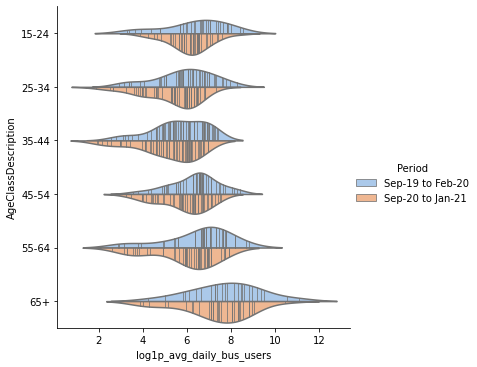

In [30]:
sns.catplot(
    y='AgeClassDescription', 
    x='log1p_avg_daily_bus_users', 
    hue='Period',
    kind='violin',
    inner='stick',
    split=True,
    palette='pastel',
    data=user_profiles_df
);

In [31]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''
    https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
    '''
    def _modify_nan(value, replacement=0.1):
        if np.isnan(value):
            return replacement
        return value
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                value = _modify_nan(value)
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = round((p.get_width()),2)
                value = _modify_nan(value)
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def facegrid_show_value_bars(g, h_v='v'):
    '''
    https://stackoverflow.com/questions/41127841/how-to-annotate-bars-in-a-seaborn-facetgrid-works-in-factorplot
    '''
    for ax in g.axes.ravel():
        show_values_on_bars(ax, h_v)
    plt.show()

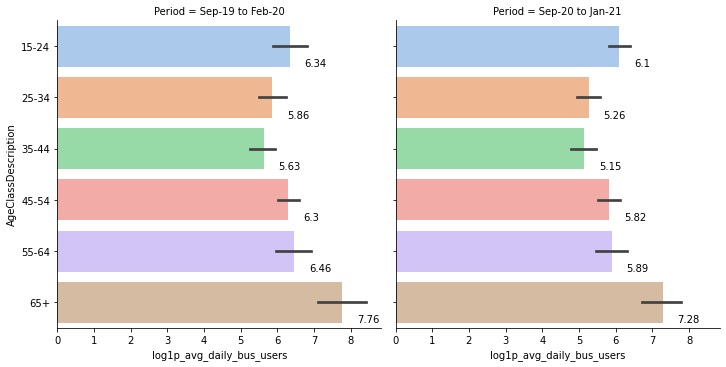

In [32]:
graph = sns.catplot(
    y='AgeClassDescription', 
    x='log1p_avg_daily_bus_users', 
    col='Period',
    kind='bar',
    palette='pastel',
    data=user_profiles_df
);
facegrid_show_value_bars(graph, h_v='h')

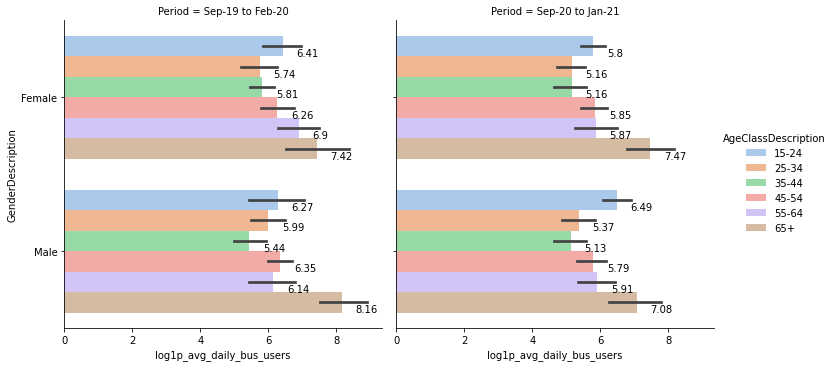

In [33]:
graph = sns.catplot(
    y='GenderDescription', 
    x='log1p_avg_daily_bus_users', 
    col='Period',
    hue='AgeClassDescription',
    kind='bar',
    palette='pastel',
    data=user_profiles_df
);
facegrid_show_value_bars(graph, h_v='h')

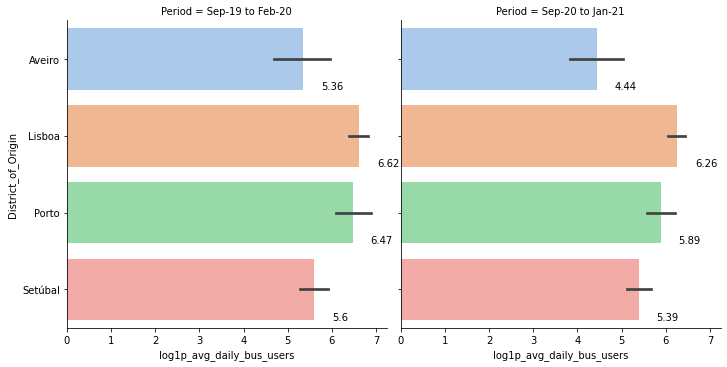

In [34]:
graph = sns.catplot(
    y='District_of_Origin', 
    x='log1p_avg_daily_bus_users', 
    col='Period',
    kind='bar',
    palette='pastel',
    data=user_profiles_df
);
facegrid_show_value_bars(graph, h_v='h')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


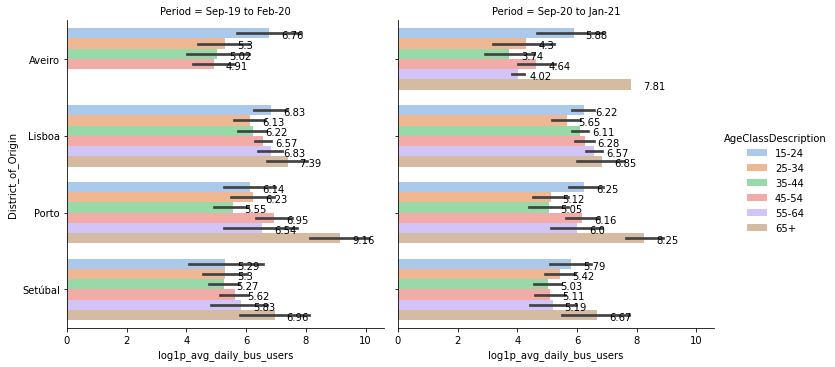

In [35]:
graph = sns.catplot(
    y='District_of_Origin', 
    x='log1p_avg_daily_bus_users', 
    col='Period',
    hue='AgeClassDescription',
    kind='bar',
    palette='pastel',
    data=user_profiles_df
);
facegrid_show_value_bars(graph, h_v='h')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


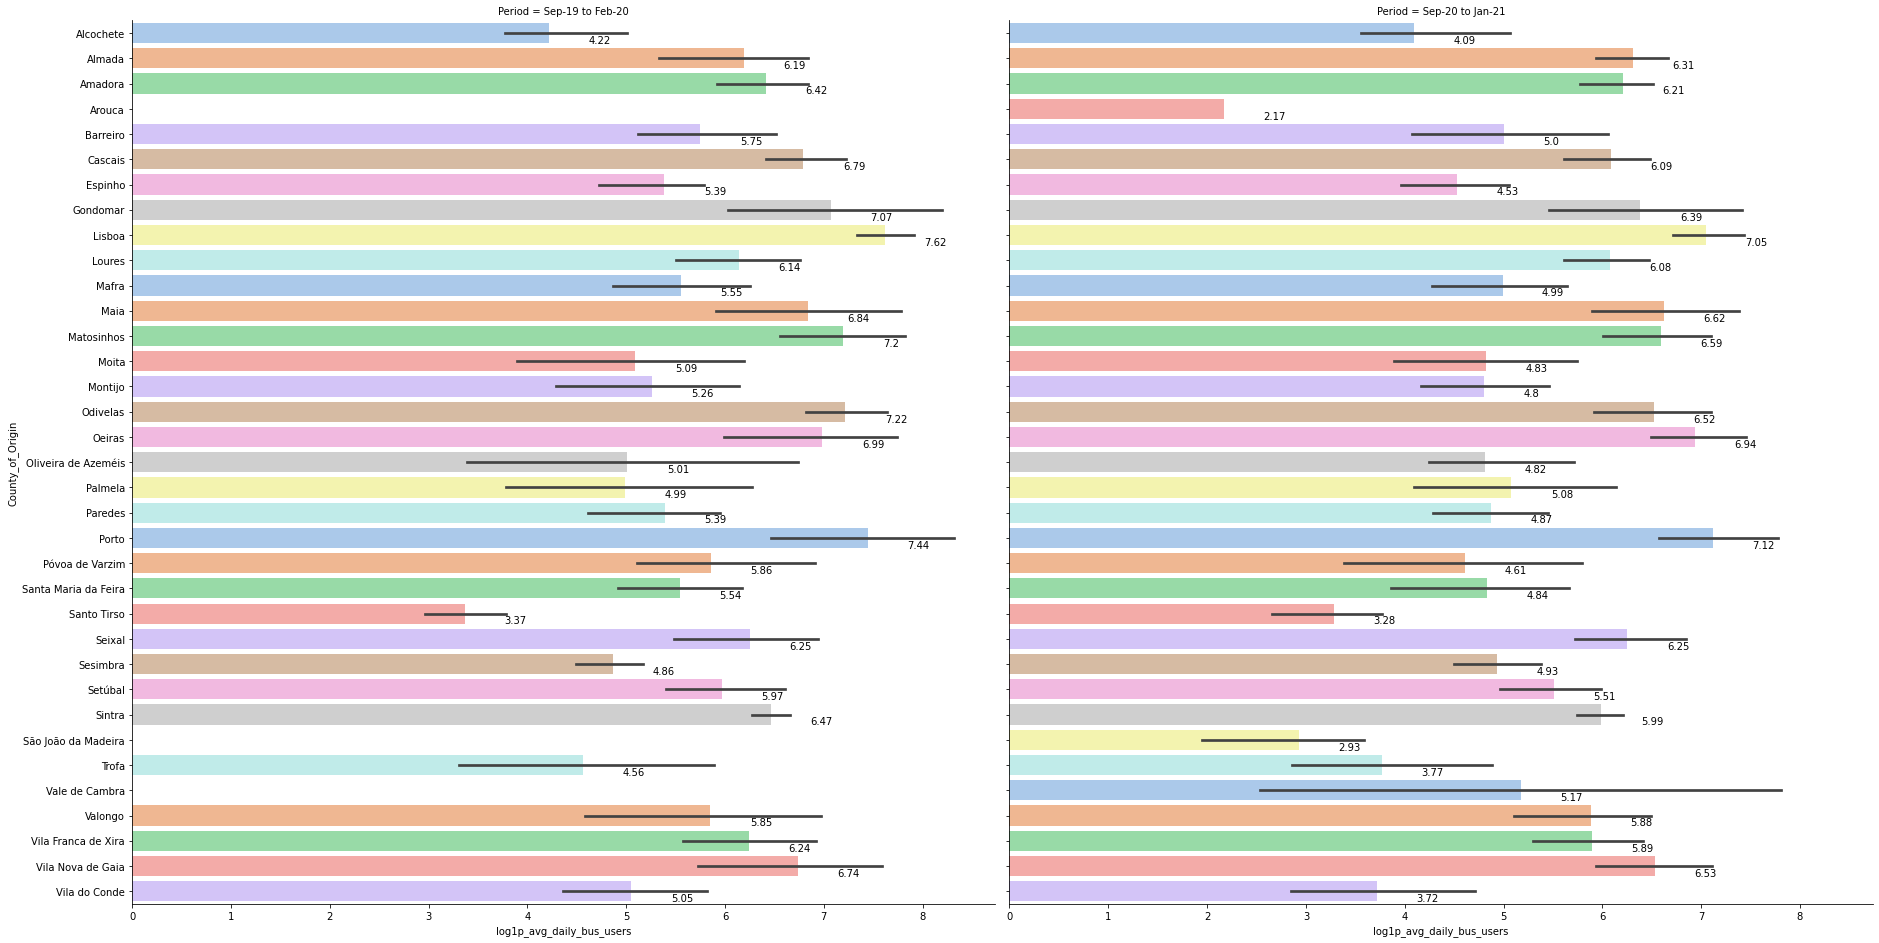

In [36]:
graph = sns.catplot(
    y='County_of_Origin', 
    x='log1p_avg_daily_bus_users', 
    col='Period',
    kind='bar',
    palette='pastel',
    data=user_profiles_df,
    height=13
);
facegrid_show_value_bars(graph, h_v='h')

Findings:
-  Across the board numbers decreased
-  55 and Upwards from Aveiro began using public transport in the second period
-  People from Arouca, Sao Joao da Madeira and Vale De Cambra began using public transport where there was no usage before
-  Very few places increased numbers from before and after; these are the signals we should look for retention
-  For all the places that have reported a decrease; we should look to find common trends among them

In [37]:
# user_profiles_df

### 2: Churn Origin-Destination (OD) Data
Notes:
-  There are no time periods for the churn OD data; would we assume that the routes have not changed across the two different time periods?
-  Vinay has done some analysis; primary findings:
    -  is that Lisboa is the primary hub with several routes leading into it
    -  there are many routes that have the same origin and destination
    -  Q: Routes that start in one city and end in another but traverse through intermediary cities; these connect via other routes?

In [38]:
# Load churn data
churn_od_df = pd.read_csv(
    os.path.join(data_dir, 'Churn_OD.txt'), 
    delimiter = "|",
    encoding = "ISO-8859-1"
)

#### 2.1: Inspect data
Notes:
-  Origin has region, district, county
-  Destination ends in 'of_Public_Transportation'
-  'Dicofre_ParishCode_of_Public_Transportation', short for 'DIstrito, COncelho, FREguesia' is the neighbourhood region
-  Demand_weight should sum to 1 for each county_origin

In [39]:
churn_od_df.sample(5)

,Region_of_Origin,District_of_Origin,County_of_Origin,Region_of_Public_Transportation,District_of_Public_Transportation,County_of_Public_Transportation,Dicofre_ParishCode_of_Public_Transportation,Demand_weight
435,R1 - AM Lisboa,Lisboa,Odivelas,R1 - AM Lisboa,LISBOA,ODIVELAS,111603,0.005865
931,R1 - AM Lisboa,Setúbal,Moita,R1 - AM Lisboa,SETÚBAL,ALMADA,150312,0.000755
639,R1 - AM Lisboa,Lisboa,Sintra,R2 - AM Porto,PORTO,VALONGO,131506,0.000000
2173,R2 - AM Porto,Porto,Vila Nova de Gaia,R2 - AM Porto,PORTO,MATOSINHOS,130814,0.019229
663,R1 - AM Lisboa,Lisboa,Vila Franca de Xira,R1 - AM Lisboa,LISBOA,LISBOA,110633,0.180072


In [40]:
# again, no missing data -> fantastic
churn_od_df.isna().sum()

Region_of_Origin                               0
District_of_Origin                             0
County_of_Origin                               0
Region_of_Public_Transportation                0
District_of_Public_Transportation              0
County_of_Public_Transportation                0
Dicofre_ParishCode_of_Public_Transportation    0
Demand_weight                                  0
dtype: int64

In [41]:
# 2253 rows
churn_od_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 8 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Region_of_Origin                             2253 non-null   object 
 1   District_of_Origin                           2253 non-null   object 
 2   County_of_Origin                             2253 non-null   object 
 3   Region_of_Public_Transportation              2253 non-null   object 
 4   District_of_Public_Transportation            2253 non-null   object 
 5   County_of_Public_Transportation              2253 non-null   object 
 6   Dicofre_ParishCode_of_Public_Transportation  2253 non-null   int64  
 7   Demand_weight                                2253 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 140.9+ KB


In [42]:
churn_od_df.dtypes

Region_of_Origin                                object
District_of_Origin                              object
County_of_Origin                                object
Region_of_Public_Transportation                 object
District_of_Public_Transportation               object
County_of_Public_Transportation                 object
Dicofre_ParishCode_of_Public_Transportation      int64
Demand_weight                                  float64
dtype: object

In [43]:
# no duplicate rows!
churn_od_df.duplicated().sum()

0

#### 2.2: Data wrangling
Data plots for discovery
-  Change naming '_Public_Transportation' to 'Destination'

In [44]:
# change column titles
churn_od_df.columns = churn_od_df.columns.str.replace('_Public_Transportation', '_Destination')

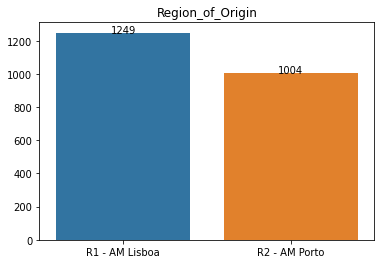

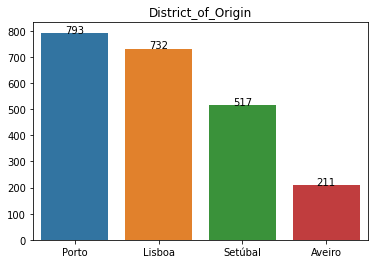

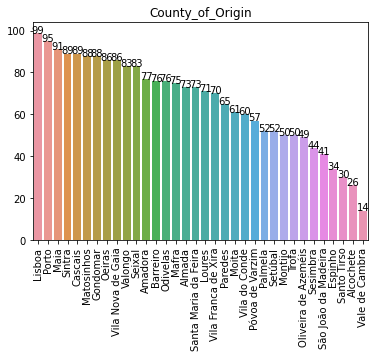

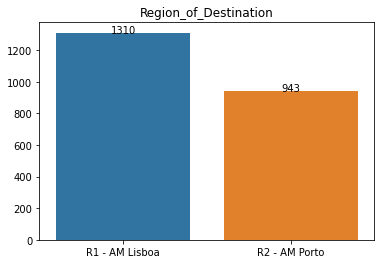

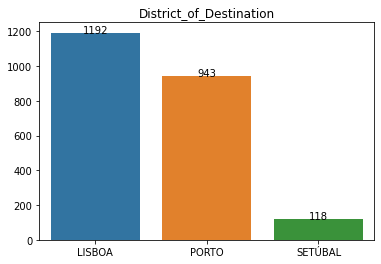

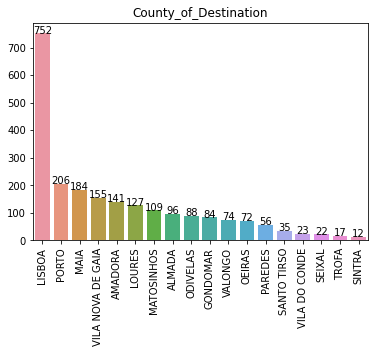

In [45]:
# plot barplots of each origin/destination
for col in churn_od_df.select_dtypes(include='object').columns:
    vcs = churn_od_df[col].value_counts()
    g = sns.barplot(data=churn_od_df, x=vcs.index.values, y=vcs.values)
    plt.title(col)
    show_values_on_bars(g)
    if 'County' in col:
        plt.xticks(rotation=90)
    plt.show()

In [46]:
def move_legend(ax, new_loc, bbox_to_anchor=None, **kws):
    '''
    https://github.com/mwaskom/seaborn/issues/2280
    '''
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    if bbox_to_anchor is not None:
        ax.legend(handles, labels, loc=new_loc, bbox_to_anchor=bbox_to_anchor, title=title, **kws)
    else:
        ax.legend(handles, labels, loc=new_loc, title=title, **kws)

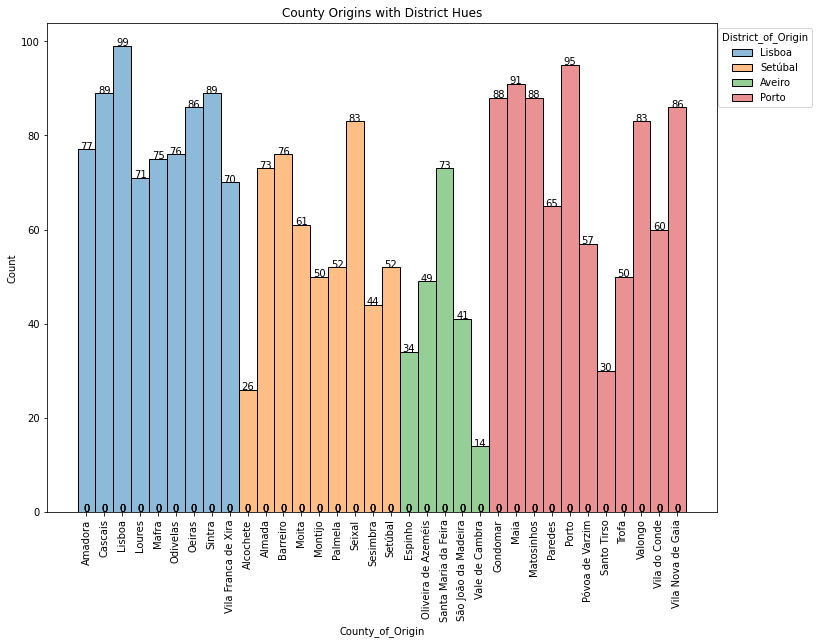

In [47]:
# plot county with hues of district/region for origin/destination
fig, ax = plt.subplots(figsize=(12,9))
g = sns.histplot(data=churn_od_df, x='County_of_Origin', hue='District_of_Origin', ax=ax)
show_values_on_bars(g)
ax.tick_params(axis='x', labelrotation=90)
move_legend(ax, 'upper right', bbox_to_anchor=(1.15, 1))
ax.set_title('County Origins with District Hues');

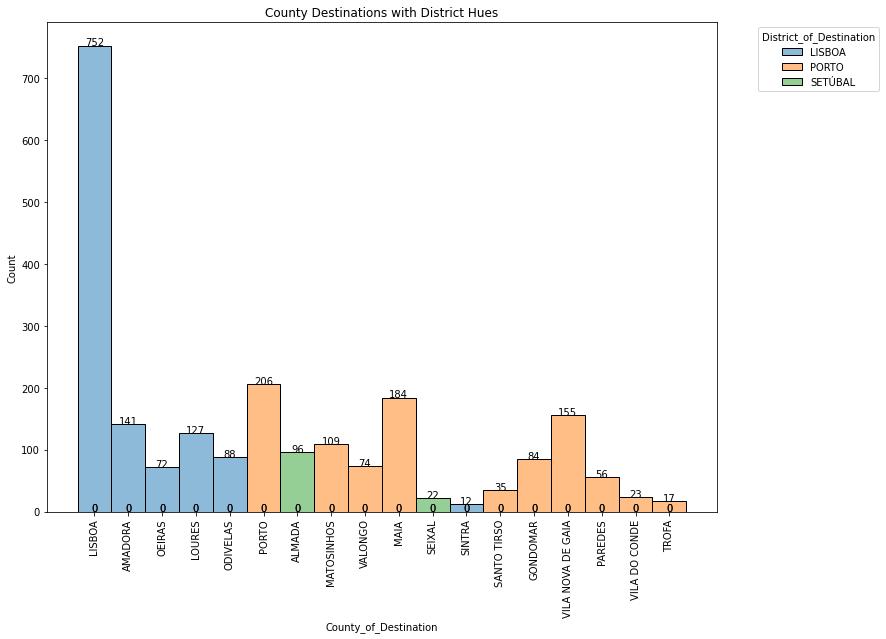

In [48]:
# plot county with hues of district/region for origin/destination
fig, ax = plt.subplots(figsize=(12,9))
g = sns.histplot(data=churn_od_df, x='County_of_Destination', hue='District_of_Destination', ax=ax)
show_values_on_bars(g)
ax.tick_params(axis='x', labelrotation=90)
move_legend(ax, 'upper right', bbox_to_anchor=(1.25, 1))
ax.set_title('County Destinations with District Hues');

In [49]:
churn_od_df['Dicofre_ParishCode_of_Destination'].value_counts()

110608    34
110610    33
110618    33
110654    33
110657    33
          ..
130613     7
130414     6
131806     6
131611     4
131809     4
Name: Dicofre_ParishCode_of_Destination, Length: 100, dtype: int64

Findings:
-  Lisboa is a more popular region of origin
-  Porto and Lisboa are close in origin districts, Aveiro is the least popular
-  Counties vary quite widely in terms of origin locations; perhaps we can try to find out which counties belong to which districts to see if there's a common trend
-  Setubal is not even an origin but exists as a destination district 
    - TODO: Investigate what links exist there? Are there even transport links that go from there?
-  Most popular county is by far Lisboa, rest are dwarfed. Raises multiple questions about travel purposes and so on..
-  Aveiro has the least number of counties and one with the lowest number of origin passengers
-  Aveiro is not even a district for destination; and setubal has two destinations. Porto has quite a few by count but lisboa by far dominates
-  There are 100 parish codes; we will not work with these for now but could be valuable to look at later on.

#### 2.3: Visualising types of routes (internal v external)

In [50]:
# breakdown of internal v external routes
churn_od_df['County_of_Origin'] = churn_od_df['County_of_Origin'].str.upper()
routes_count = (churn_od_df.groupby('County_of_Origin')
                           .agg({"County_of_Origin": 'count'})
                           .rename(columns={'County_of_Origin': 'number_of_routes'})
                           .sort_values(by=['number_of_routes'], ascending = False))

churn_od_df_internal = churn_od_df[churn_od_df['County_of_Destination'] == churn_od_df['County_of_Origin']]
churn_od_df_internal_agg = (churn_od_df_internal.groupby('County_of_Origin')
                    .agg({'County_of_Origin': 'count'})
                    .rename(columns={'County_of_Origin': 'number_of_routes_internal'}))
            

routes_count_final = pd.merge(routes_count, churn_od_df_internal_agg, left_index=True, right_index=True,  how = 'inner')
routes_count_final['percentage_of_routes_internal'] = routes_count_final['number_of_routes_internal']/ routes_count_final['number_of_routes']
routes_count_final['number_of_routes_external'] =  routes_count_final['number_of_routes'] - routes_count_final['number_of_routes_internal']
routes_count_final['percentage_of_routes_external'] =  1-  routes_count_final['percentage_of_routes_internal']
routes_count_final

,number_of_routes,number_of_routes_internal,percentage_of_routes_internal,number_of_routes_external,percentage_of_routes_external
County_of_Origin,,,,,
LISBOA,99,24,0.242424,75,0.757576
PORTO,95,7,0.073684,88,0.926316
MAIA,91,10,0.109890,81,0.890110
SINTRA,89,1,0.011236,88,0.988764
GONDOMAR,88,5,0.056818,83,0.943182
MATOSINHOS,88,4,0.045455,84,0.954545
VILA NOVA DE GAIA,86,10,0.116279,76,0.883721
OEIRAS,86,3,0.034884,83,0.965116
VALONGO,83,4,0.048193,79,0.951807


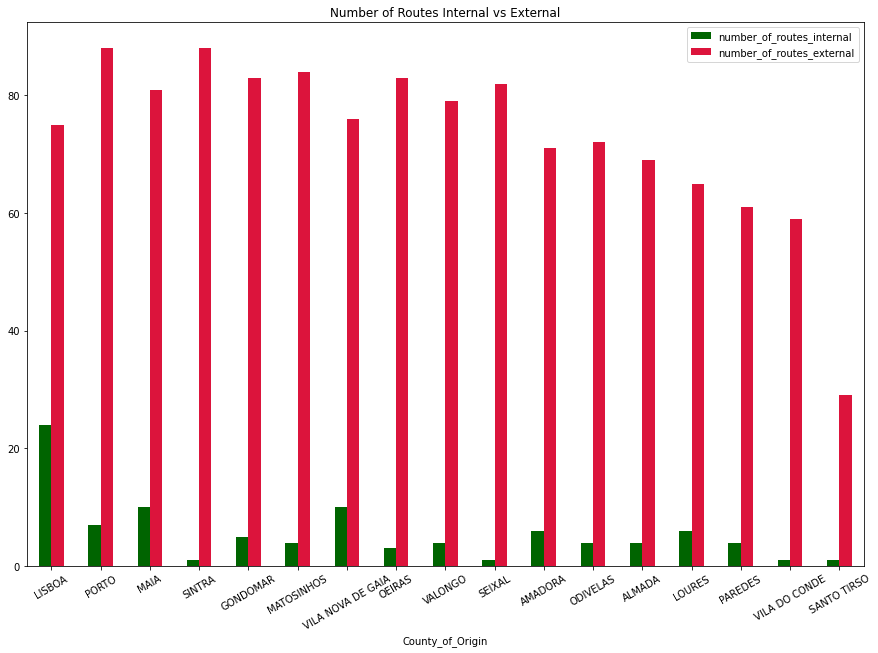

In [51]:
# plot number of internal vs external routes
routes_count_final[
    ['number_of_routes_internal', 'number_of_routes_external']
    ].plot.bar(rot=30, color=['darkgreen', 'crimson'], figsize=(15,10))
plt.title('Number of Routes Internal vs External');

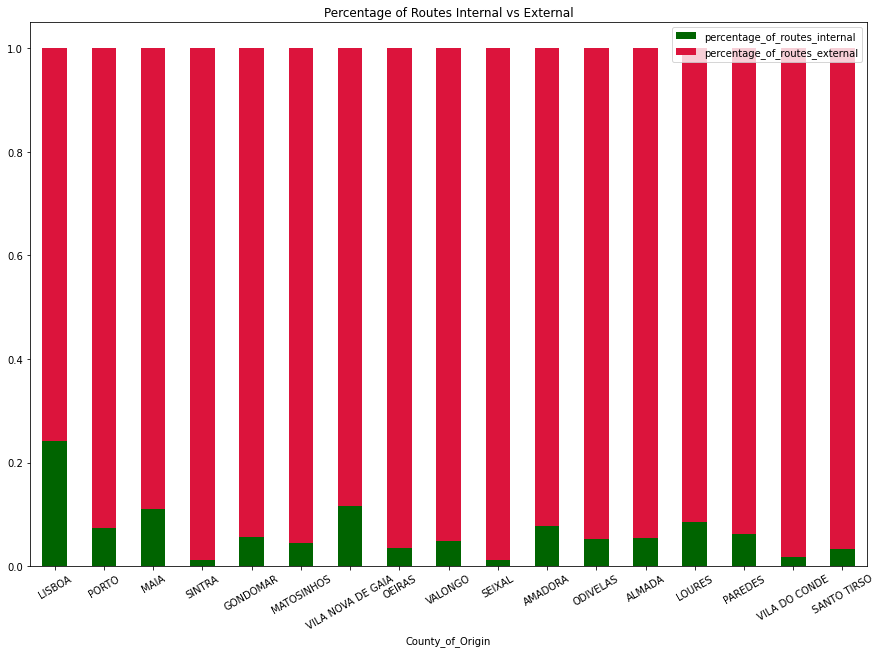

In [52]:
# plot percentage vs external routes
routes_count_final[
    ['percentage_of_routes_internal', 'percentage_of_routes_external']
    ].plot.bar(
    rot=30, color=['darkgreen', 'crimson'], figsize=(15,10), stacked=True
)
plt.title('Percentage of Routes Internal vs External');

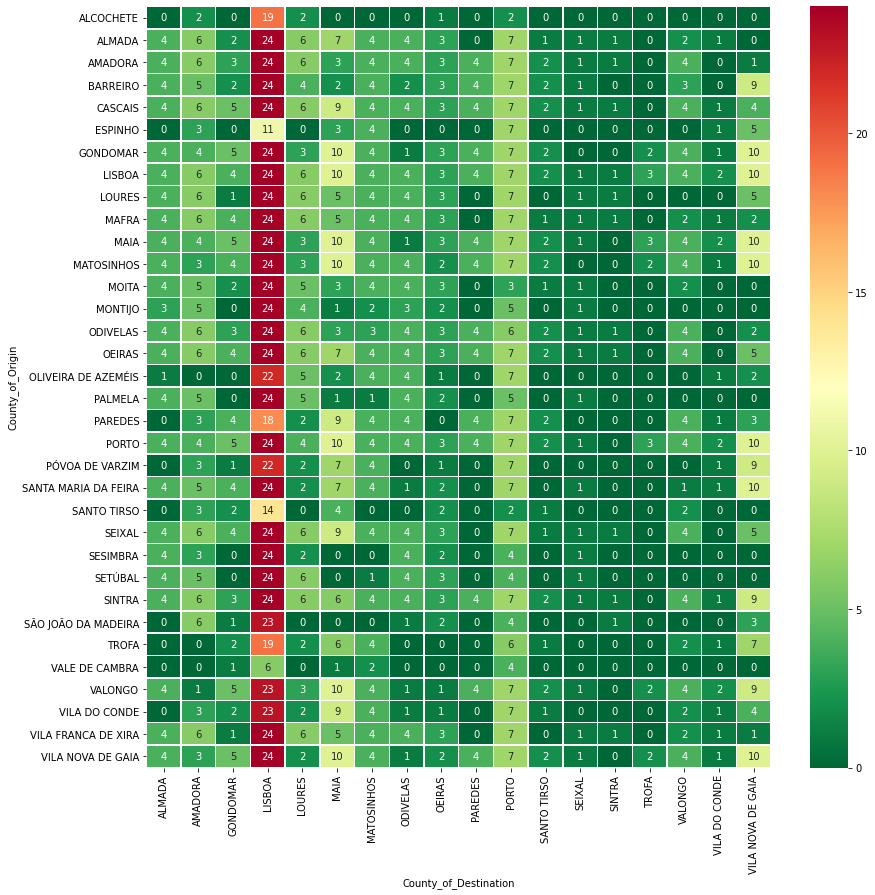

In [53]:
# plot a heatmap
fig, ax = plt.subplots(figsize=(14,14))  
sns.heatmap(
    pd.crosstab(
        churn_od_df.County_of_Origin, 
        churn_od_df.County_of_Destination
    ),
    annot=True,
    cmap='RdYlGn_r', 
    linewidths=0.5,
    ax=ax
);

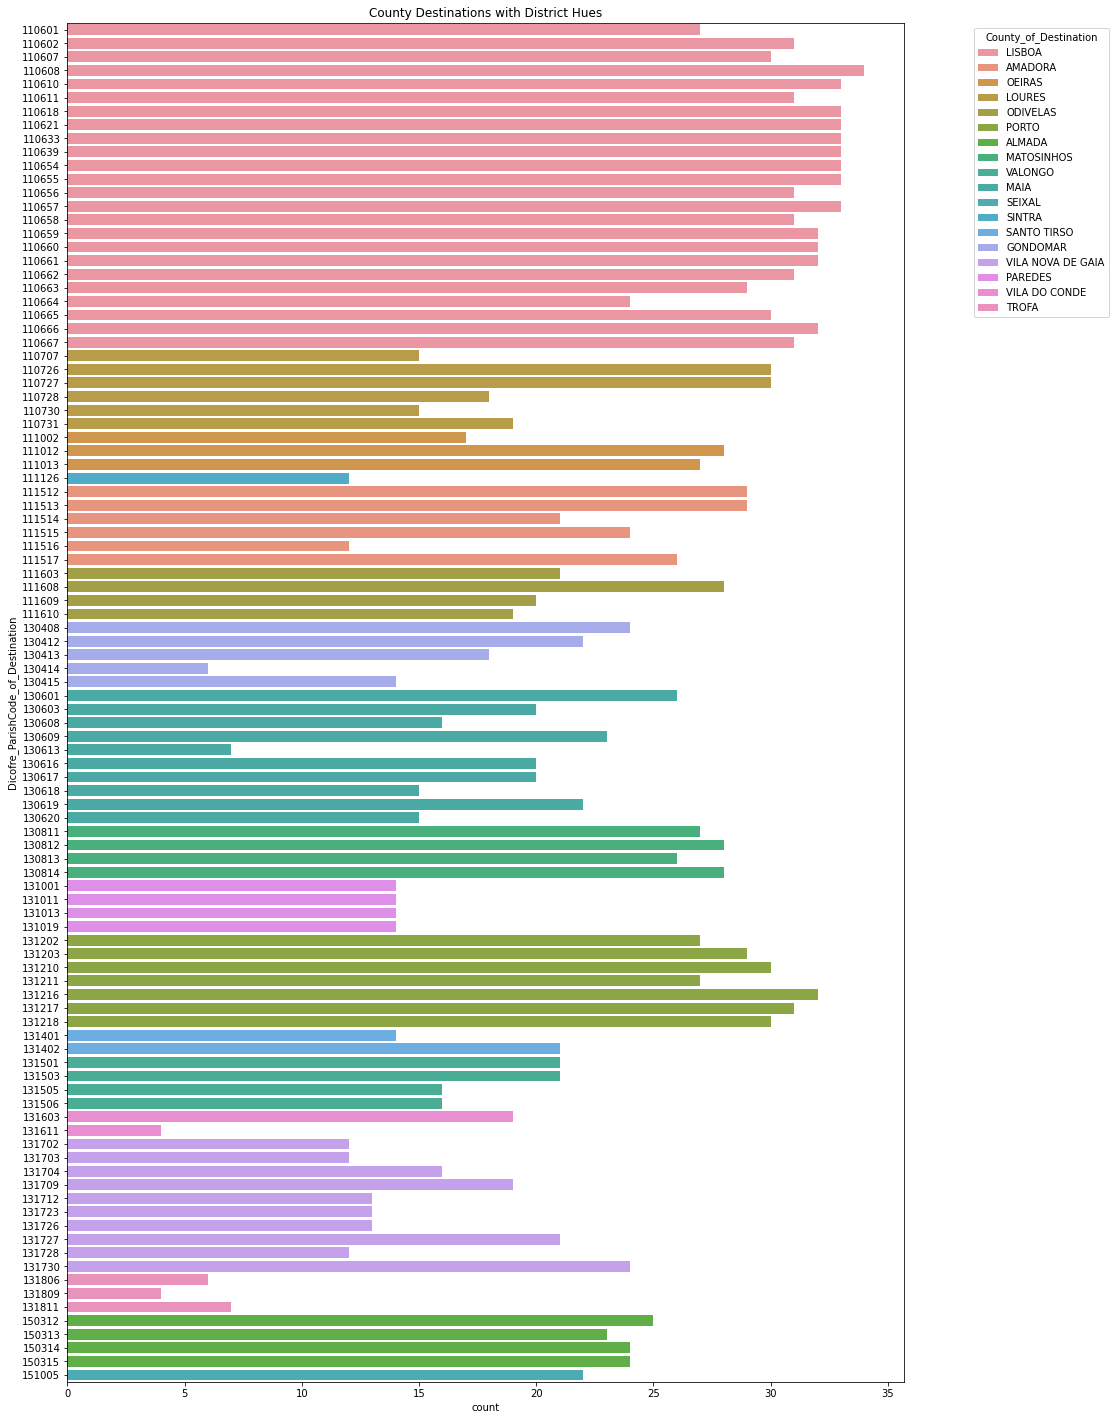

In [77]:
fig, ax = plt.subplots(figsize=(15,25))
sns.countplot(
    y='Dicofre_ParishCode_of_Destination', 
    hue='County_of_Destination',
    dodge=False,
    data=churn_od_df,
);
move_legend(ax, 'upper right', bbox_to_anchor=(1.25, 1))
ax.set_title('Parish Codes for Destinations colored by District Hues');

Findings:
-  There are far more routes going out than there are going in
-  Lisboa has the highest number of routes going in
    -  Does this mean all of the other places are going to Lisboa?
    -  Pretty much verified by the heatmap.. Perhaps we can build a graph network next but the heatmap depicts what is happening
-  Parish codes give us more granularity but we only have the destinations.. Can we get the shapefiles or latitude/longitude of these to map out and understand the network effect of what is happening?

#### 2.4: Building a Graph Network
Numerically assess the hubs/clusters etc..

In [54]:
churn_od_df

,Region_of_Origin,District_of_Origin,County_of_Origin,Region_of_Destination,District_of_Destination,County_of_Destination,Dicofre_ParishCode_of_Destination,Demand_weight
0,R1 - AM Lisboa,Lisboa,AMADORA,R1 - AM Lisboa,LISBOA,LISBOA,110608,0.307323
1,R1 - AM Lisboa,Lisboa,AMADORA,R1 - AM Lisboa,LISBOA,LISBOA,110639,0.069997
2,R1 - AM Lisboa,Lisboa,AMADORA,R1 - AM Lisboa,LISBOA,LISBOA,110658,0.066059
3,R1 - AM Lisboa,Lisboa,AMADORA,R1 - AM Lisboa,LISBOA,LISBOA,110654,0.059847
4,R1 - AM Lisboa,Lisboa,AMADORA,R1 - AM Lisboa,LISBOA,LISBOA,110633,0.052341
...,...,...,...,...,...,...,...,...
2248,R2 - AM Porto,Porto,VILA NOVA DE GAIA,R1 - AM Lisboa,SETÚBAL,ALMADA,150315,0.000000
2249,R2 - AM Porto,Porto,VILA NOVA DE GAIA,R2 - AM Porto,PORTO,GONDOMAR,130414,0.000000
2250,R2 - AM Porto,Porto,VILA NOVA DE GAIA,R1 - AM Lisboa,LISBOA,ODIVELAS,111608,0.000000
2251,R2 - AM Porto,Porto,VILA NOVA DE GAIA,R1 - AM Lisboa,SETÚBAL,ALMADA,150313,0.000000
